### 1. Analysis: Frame the problem and look at the big picture

For the 7th assignment our group decided to partake in Ion's bachelor project idea, as we found it to be interesting and we could help him achieve his goals for BPR.<br>
The objective put into simple terms is to: create an interpreter for the American Sign Language which can be used for online direct communication, or teaching purposes. It would benefit the communication between deaf and hearing communities. <br>
The problem would be supervised, as there are existing labels which represent words translated from the sign-language videos.<br>
The performance would be measured in precision of the model.

### 2. Get the data

The data set can be found on [Keggle - WLASL (World Level American Sign Language) Video](https://www.kaggle.com/datasets/risangbaskoro/wlasl-processed). <br>
At first glance, the dataset looks pretty promising. <br>
IT contains a lot of video metadata and is very specific to a certain video library that needs to get downloaded from a different source - hosted [here](https://drive.google.com/file/d/11eFE_quM2_2-h3H_zTTjq0i0D6pkx62Z/view). 


### 3. Explore the data
After a copy of the data was downloaded, we inspected its content. <br>
That is the moment we found out that half of the videos mentioned in the data set were missing, so we requested a new copy of all the videos from the original source. This time we got all the videos.<br>
The features in this case are just videos, more precisely .mp4 videos. Of course processing them would come a bit later, but at this point tu a simple user they are just videos.<br>
The targets are simply the words that each of the video tries to demonstrate, meaning that if the video is labeled with the word "friend", then it will simply represent a person showing the specific sign in American Sign Language for the word "friend" <br>
Visualizing the video would simple mean watching the video, or representing the number of samples for each word. Even though there are not a lot of samples, a key point is that each of them are <br>
There is no transformations that would need to be applied to the data as of this point in time, because the main idea behind it is that a third-party library from Google [MediaPipe](https://mediapipe.dev/) would add a layer on top of the videos, tracking the objects (hands, movements, faces). Further on, the real features would be given by MediaPipe, and they do not need any transformation or scaling whatsoever. <br>
A visualization of how MediaPipe works is available below: <br> 
<br>
 ![alt text](https://mediapipe.dev/assets/img/photos/pose_1.jpg)
<br>
MediaPipe can be fired up on different sources, such as live video - webcam, or pre-recorder video

All the needed imports:

In [1]:
import mediapipe as mp
import cv2
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
import random
from sklearn import (datasets, decomposition, ensemble, 
                     metrics, model_selection, preprocessing)
import matplotlib.pyplot as plt

In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic
mp_hands = mp.solutions.hands

### 4. Prepare the data

First steps in preparing the data is using MediaPipe to extract the landmarks. MediaPipe detects 33 body landmarks in total, but given that the Sign Language is only expressed through upper-body and hand movements, we scraped a lot of the unimportant landmarks and used the 12 most important ones from the body in this case, represented below: <br> <br> ![body landmarks](mediapipe_landmarks.jpg) <br> <br>
As the details of specific words in the sign language can be found in the hand and finger movement, all of the landmarks that MediaPipe offers were used, a representation can be seen below: <br> <br> ![body landmarks](hand_landmarks.png)

In [3]:
def mediapipe_detection(image, holistic,hands):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR to RGB
    image.flags.writeable = False                  # Image is no longer writeable
    holistic_model = holistic.process(image)                 # Make prediction
    hands_model = hands.process(image)
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    
    resize_up = cv2.resize(image, (1024,800), interpolation= cv2.INTER_AREA)

    return resize_up, holistic_model,hands_model

This is an optional method which is used to draw the landmarks on top of the images that we might feed into the model. It can be used for live demos.

In [4]:
def draw_landmarks(image, pose,hands):
    if(pose.pose_world_landmarks):
        mp_drawing.draw_landmarks(image, pose.pose_world_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
            # Draw pose connections
        mp_drawing.draw_landmarks(image, pose.pose_world_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    if hands.multi_hand_landmarks:
        for hand_landmarks in hands.multi_hand_landmarks:
            mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS) # Draw hands
                # Draw right hand connections  
            mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )

We had multiple options for extracting data from the video using MediaPipe. First was using holistic solution, which allows the extraction of pose, left hand and right hand marks. In this case hand tracking allows the extraction of X, Y and Z coordinates, and works fairly well, while the pose one allows only for X and Y coordinates, Z not being fully precise enough in the model that's offered by MediaPipe. Using this option meant that the origin was in the lower-left extreme of the image - further normalized to [0.0, 1.0]. The second option was using the pose_world landmark which allowed taking the real world 3-D coordinates in meters with the origin being in the center between hips, and the hands tracked by the multi_hand_world_landmarks property, where the origin of the hands is at the base of the palms.

This function detects the 12 body landmarks that we talked about above, getting their X and Y coordinates. It returns NaN if they are not detected or the landmarks as an array when detected.

In [5]:
def convert_pose_world_to_array(hollistic):
    landmarks = hollistic.pose_world_landmarks
    data = []
    
    if(landmarks == None):
        return None
    else:
        landmarks = landmarks.landmark[11:23]
        for item in landmarks:
            if(item==None):
                data.append(None)
            else:
                landmark = {'X':item.x,'Y':item.y}
                data.append(landmark)
    return data

This function detects all 21 hand landmarks, splitting them by each hand (right or left). Every hand returns an array of coordinates (nan or values) same as for the pose. If there is only one hand detected, or if both hands are detected but they are in the same position (i.e. both are left or both are right), the code determines the landmarks of the hand using the multi_hand_world_landmarks property of the hands input. The landmarks are then returned as a list of dictionaries with the 3D coordinates of the landmarks.


In [6]:
def get_left_and_right_hand_landmarks( hands):
    hands_position = hands.multi_handedness
    hands_landmarks = hands.multi_hand_world_landmarks
    
    if not hands_position:
        return [None, None]
        
    second_hand=None

    first_hand = hands_position[0].classification[0]
    if(len(hands_position) == 2):
        second_hand = hands_position[1].classification[0]

    if len(hands_position) == 1 or (second_hand and first_hand.label == second_hand.label):
        if(len(hands_position) == 2 and first_hand.score < second_hand.score):
            landmarks = hands_landmarks[1].landmark
        else:
            landmarks = hands_landmarks[0].landmark
        hand = []
        for item in landmarks:
            hand.append({'X': item.x, 'Y': item.y, 'Z': item.z})

        if hands_position[0].classification[0].label == 'Left':
            return [None,hand]

        return [hand,None]

    left_hand = []
    right_hand = []
    left_hand_landmarks = hands_landmarks[0].landmark
    right_hand_landmarks = hands_landmarks[1].landmark
    for i in range(len(left_hand_landmarks)):
        right_hand.append({'X': left_hand_landmarks[i].x, 'Y': left_hand_landmarks[i].y, 'Z': left_hand_landmarks[i].z})
        left_hand.append({'X': right_hand_landmarks[i].x, 'Y': right_hand_landmarks[i].y, 'Z': right_hand_landmarks[i].z})

    return [left_hand, right_hand]

Getting the top 5 words that we use for this model's predictions

In [7]:
data = pd.read_json("Data.json")
top_words = ['thank you','love','deaf',"hello","friend"]

X_thank_you = data[data['label']=="thank you"]
X_love= data[data['label']=="love"]
X_deaf = data[data['label']=="deaf"]
X_hello = data[data['label']=="hello"]
X_friend = data[data['label']=="friend"]

data_type = {"RIGHT_HAND_WORLD_LANDMARKS": [], "LEFT_HAND_WORLD_LANDMARKS":[],"POSE_WORLD_LANDMARKS":[],"Label":[]}
X = np.concatenate((X_thank_you,X_love,X_deaf,X_hello,X_friend))

In [9]:
MyList = ["b", "a", "a", "c", "b", "a", "c", 'a']


{'b': 2, 'a': 4, 'c': 2}


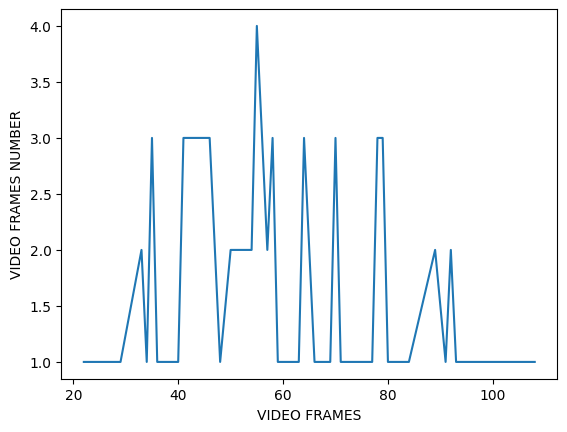

In [20]:


Folder = "C:/Users/ion/Desktop/WLASL ML PROCESSING/WLASL2000/WLASL2000/"
video_length = []
for item in X:
    cap = cv2.VideoCapture(Folder + str(item[1]).zfill(5) + ".mp4")
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    video_length.append(length)
video_length.sort()
res = {i:video_length.count(i) for i in video_length}

video_frames = []
vide_frames_count = []
for item in res:
    video_frames.append(item)
    vide_frames_count.append(res[item])

plt.xlabel("VIDEO FRAMES")
plt.ylabel("VIDEO FRAMES NUMBER")
plt.plot(video_frames,vide_frames_count)
plt.show()

This code is processing a dataset of videos by extracting information about hand and body pose. The code iterates over a list of videos, indicated by the variable X, and extracts pose data using the mediapipe_detection function. The pose data is then converted and appended to the data_type dictionary, which is likely used to store the extracted data. The code also includes a check to see if the video capture was successful, and breaks the loop if not.

In [ ]:
Folder = "C:/Users/ion/Desktop/WLASL ML PROCESSING/WLASL2000/WLASL2000/"
index = 0
for item in X:
    print(item)
    print(Folder + str(item[1]).zfill(5) + ".mp4")
    cap = cv2.VideoCapture(Folder + str(item[1]).zfill(5) + ".mp4")
    right_hand = []
    left_hand = []
    pose_shape = []
    pose_world = []
    right_hand_world = []
    left_hand_world = []
    data_type["Label"].append(item[0].lower())
    print(index)
    index = index+1
    with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as pose:
        with mp_hands.Hands(min_detection_confidence=0.3,min_tracking_confidence=0.3) as hands:
            while(cap.isOpened()):
                success, frame = cap.read()
                if(not success):
                    break
                if(success):
                    frame.flags.writeable = False
                    image,hollistic,hands_position = mediapipe_detection(frame,pose,hands)
                    pose_world.append(convert_pose_world_to_array(hollistic))

                    hands_world_landmarks = get_left_and_right_hand_landmarks(hands_position)

                    left_hand_world.append(hands_world_landmarks[0])
                    right_hand_world.append(hands_world_landmarks[1])
                    
    data_type["POSE_WORLD_LANDMARKS"].append(pose_world)   
    data_type["LEFT_HAND_WORLD_LANDMARKS"].append(left_hand_world)
    data_type["RIGHT_HAND_WORLD_LANDMARKS"].append(right_hand_world)

In [ ]:
# df = pd.DataFrame.from_dict(data_type)
# df.to_json('5_words_data.json',orient='index')
df = pd.read_json('5_words_data.json',orient='index')

As if data consistency is very important for the model, all the videos should be transformed into 60 frames total, resulting in a 30fps. There were a lot of different frames per video. In the cases were a video had more frames, then we checked the hands, if both of them are none - we remove the frame, otherwise, we just crop and select the first 60 frames. If the video has less than 60 frames in total, then we just add NaN to the end of them.

In [ ]:
def get_removed_index_from_world_landmarks(right_hand,left_hand):
    removed_indexes = []
    # print((right_hand)==None)
    for i in range(len(right_hand)):
        if(len(right_hand) - len(removed_indexes) <=60):
            break
        if(right_hand[i] == None and left_hand[i] == None):
            removed_indexes.append(i)
    return removed_indexes

In [ ]:
def convert_to_60_frames(data):
    for item in data.iterrows():
        world_remove_indexes = get_removed_index_from_world_landmarks(item[1].RIGHT_HAND_WORLD_LANDMARKS,item[1].LEFT_HAND_WORLD_LANDMARKS)

        if(len(item[1].RIGHT_HAND_WORLD_LANDMARKS)<60):
            current_length = len(item[1].RIGHT_HAND_WORLD_LANDMARKS)
            for i in range(current_length,60):
                item[1].RIGHT_HAND_WORLD_LANDMARKS.append(None)
                item[1].LEFT_HAND_WORLD_LANDMARKS.append(None)
                item[1].POSE_WORLD_LANDMARKS.append(None)

        
        for index in sorted(world_remove_indexes, reverse=True):
            del item[1].RIGHT_HAND_WORLD_LANDMARKS[index]
            del item[1].LEFT_HAND_WORLD_LANDMARKS[index]
            del item[1].POSE_WORLD_LANDMARKS[index]
            
        if(len(item[1].RIGHT_HAND_WORLD_LANDMARKS)>60):
            del item[1].RIGHT_HAND_WORLD_LANDMARKS[60:]
            del item[1].LEFT_HAND_WORLD_LANDMARKS[60:]
            del item[1].POSE_WORLD_LANDMARKS[60:]

These functions are used to convert the coordinates (X, Y, Z) from pose and hands to the 60x150 array were 60 is the number of frames and 150 is the total number of points from both hands and the pose.

In [ ]:
sequences = []
labels = []
def extract_keypoints(pose_world_landmarks,right_hand_world_landmarks,left_hand_world_landmarks):
    pose = np.array([[res['X'], res['Y']] for res in pose_world_landmarks]).flatten() if pose_world_landmarks[0] else np.zeros(12*2)
    lh = np.array([[res['X'], res['Y'], res['Z']] for res in left_hand_world_landmarks ]).flatten() if left_hand_world_landmarks  else np.zeros(21*3)
    rh = np.array([[res['X'], res['Y'], res['Z']] for res in right_hand_world_landmarks ]).flatten() if right_hand_world_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

def convert_world_to_2d_array(data):
    k = 0
    for item in data.iterrows():
        sequence = []
        labels.append(item[1].Label)
        for i in range(len(item[1].RIGHT_HAND_WORLD_LANDMARKS)):    
            pose_world = item[1].POSE_WORLD_LANDMARKS[i]
            if pose_world == None:
                pose_world = [None]
            points = extract_keypoints(pose_world,item[1].RIGHT_HAND_WORLD_LANDMARKS[i],item[1].LEFT_HAND_WORLD_LANDMARKS[i])
            sequence.append(points)
        sequences.append(sequence)
        k= k+1

In [ ]:
convert_to_60_frames(df)
convert_world_to_2d_array(df)

One hot encoding the words

In [ ]:

X = np.array(sequences,dtype=float)
words = np.array(labels).reshape(-1,1)
print(words)
Y = OneHotEncoder().fit_transform(words).toarray()

Set the random seed to 69

In [ ]:
def reset_random_seeds():
   tf.random.set_seed(69)
   np.random.seed(69)
   random.seed(69)


In [ ]:
X.shape,Y.shape

Splitting data into tran and test

In [ ]:
X_train, X_test , y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=69,stratify = Y)

### 5. Short-list promising models
###### and
### 6. Fine-tune the system

In [ ]:
reset_random_seeds()


model = Sequential()
# input layer
model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(60,150)))

#hidden layers
model.add(LSTM(256, return_sequences=True, activation='relu'))
model.add(LSTM(256, return_sequences=True, activation='relu'))
model.add(LSTM(128, return_sequences=False, activation='relu'))

model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

#output layer
model.add(Dense(Y.shape[1], activation='softmax'))


model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=430,batch_size=10,validation_split = 0.2,verbose = 1)


In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Learning curves")
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'valid')
plt.legend()
plt.show()

In [ ]:
print("Accuracy on training data: {}".format(model.evaluate(X_train, y_train)))
print("Accuracy on test data: {}".format(model.evaluate(X_test, y_test)))

In [ ]:

top_words = np.array(['thank you', 'love', 'deaf', 'hello','friend'])
actual =  np.take(top_words,[np.argmax(pred) for pred in y_test])
predicted = np.take(top_words,[np.argmax(pred) for pred in model.predict(X_test)])
confusion_matrix = metrics.confusion_matrix(actual, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['thank you', 'love', 'deaf', 'hello','friend'])

cm_display.plot()
plt.show()


Accuracy = metrics.accuracy_score(actual, predicted)
Precision = metrics.precision_score(actual, predicted, average="weighted")
Sensitivity_recall = metrics.recall_score(actual, predicted, average="weighted")
F1_score = metrics.f1_score(actual, predicted, average="weighted")

print("Accuracy measures how often the model is correct: {}".format(Accuracy))
print("Precision measures percentage of true positive: {}".format(Precision))
print("Sensitivity is good at understanding how well the model predicts something is positive: {}".format(Sensitivity_recall))
print("F-score is the harmonic mean of precision and sensitivity. It considers both false positive and false negative cases: {}".format(F1_score))

As we had to build more than one model, we decided to go with a KNN algorithm and a Random Forrest.
To get a better working models, we used a GridSearch, which takes up different possible parameters to construct the model and runs through all of them to find out the best ones. 

K-nearest neighbors (KNN) is a simple and effective method for classification and regression. In the context of predicting sign language from videos, KNN could potentially be used because it is a non-parametric method that does not make any assumptions about the underlying data distribution. This means that it can model complex, non-linear relationships between the input data (the videos) and the output labels (the predicted sign language gestures). Additionally, KNN is relatively easy to implement and can be used for multi-class classification, which would be necessary in this case where there are multiple possible sign language gestures to predict.

Fine-tuning the hyperparameters in the K-nearest neighbors (KNN) algorithm. The n_neighbors parameter specifies the number of data points used to make predictions for a given data point. The metric parameter specifies the method used to measure the distance between data points. Choosing the right values for these parameters can be important for achieving good results with the KNN algorithm. that is why the number of neighbors might go up to 15 in this case, and minkowski, euclidean and manhattan are all possible good metrics that can be used.

In [ ]:
# KNN
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

X_reshaped= X.reshape(X.shape[0], (X.shape[1]*X.shape[2]))
Y_reshaped = words.flatten()
X_train, X_test , y_train, y_test = train_test_split(X_reshaped, Y_reshaped, test_size=0.2, random_state=69,stratify = Y_reshaped)

parameters = {'n_neighbors':range(1,15,2),'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan'],
               'algorithm':['ball_tree','kd_tree','brute']}

# X_R.shape,words.shape
grid_search = GridSearchCV(KNeighborsClassifier(),parameters,cv=5,refit=True,return_train_score=True,verbose = 4)


grid_search.fit(X_train,y_train)

print("Best Parameter : {}".format(grid_search.best_params_))
print("Best Cross Validation Score : {}".format(grid_search.best_score_))
print("Best estimator : {}".format(grid_search.best_estimator_))

In [ ]:
# print("Test Score : {}".format(grid_search.score(X_test_knn,Y_test_knn)))
knn = KNeighborsClassifier(algorithm= 'ball_tree', metric =  'manhattan', n_neighbors= 3, weights= 'distance')

kNN_y_pred = knn.fit(X_train, y_train).predict(X_test)
print(y_test)

In [ ]:
top_words = np.array(['thank you', 'love', 'deaf', 'hello','friend'])
actual = y_test
predicted = kNN_y_pred

confusion_matrix = metrics.confusion_matrix(actual, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['thank you', 'love', 'deaf', 'hello','friend'])

cm_display.plot()
plt.show()


Accuracy = metrics.accuracy_score(actual, predicted)
Precision = metrics.precision_score(actual, predicted, average="weighted")
Sensitivity_recall = metrics.recall_score(actual, predicted, average="weighted")
F1_score = metrics.f1_score(actual, predicted, average="weighted")

print("Accuracy measures how often the model is correct: {}".format(Accuracy))
print("Precision measures percentage of true positive: {}".format(Precision))
print("Sensitivity is good at understanding how well the model predicts something is positive: {}".format(Sensitivity_recall))
print("F-score is the harmonic mean of precision and sensitivity. It considers both false positive and false negative cases: {}".format(F1_score))

Random forests are a type of machine learning algorithm that can be used for a variety of tasks, including video processing. One reason to use a random forest for video processing is that they can handle a large number of input variables, which is useful when working with high-dimensional data like video frames. Additionally, random forests are able to learn complex nonlinear relationships between input variables and the output, which can be useful for tasks like object recognition in video. Furthermore, random forests are relatively simple to implement and interpret, which can be helpful when working with video data.

Fine-tuning the hyperparams for random-forests: n_estimators specifies the number of trees in the random forest. Criterion specifies the function used to measure the quality of a split in the decision trees. Max_features specifies the maximum number of features considered when splitting a node. Min_samples_leaf specifies the minimum number of samples required to be at a leaf node.

In [ ]:
parameters = {'n_estimators':range(100, 200, 10), 'criterion': ['gini','entropy'], 'max_features': ['log2', 'sqrt'], 'min_samples_leaf': range(5, 10), }  
grid_search = GridSearchCV(RandomForestClassifier(),parameters,cv=5,refit=True,return_train_score=True,verbose = 4)  
grid_search.fit(X_train,y_train)  
  
print("Best Parameter : {}".format(grid_search.best_params_))  
print("Best Cross Validation Score : {}".format(grid_search.best_score_))  
print("Best estimator : {}".format(grid_search.best_estimator_))
rf = RandomForestClassifier(criterion='entropy', min_samples_leaf=5,random_state=69) 
rf_pred = rf.fit(X_train,y_train).predict(X_test)
top_words = np.array(['thank you', 'love', 'deaf', 'hello','friend']) 
actual = y_test 
predicted = rf_pred 
 
confusion_matrix = metrics.confusion_matrix(actual, predicted) 
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['thank you', 'love', 'deaf', 'hello','friend']) 
 
cm_display.plot() 
plt.show() 
 
 
Accuracy = metrics.accuracy_score(actual, predicted) 
Precision = metrics.precision_score(actual, predicted, average="weighted") 
Sensitivity_recall = metrics.recall_score(actual, predicted, average="weighted") 
F1_score = metrics.f1_score(actual, predicted, average="weighted") 
 
print("Accuracy measures how often the model is correct: {}".format(Accuracy)) 
print("Precision measures percentage of true positive: {}".format(Precision)) 
print("Sensitivity is good at understanding how well the model predicts something is positive: {}".format(Sensitivity_recall)) 
print("F-score is the harmonic mean of precision and sensitivity. It considers both false positive and false negative cases: {}".format(F1_score))v